In [14]:
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
from torch.utils.data import DataLoader, TensorDataset

# Load data
digits = load_digits()
X = digits.data               
y = digits.target           

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=231)

# Normalize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert to tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)   
y_test = torch.tensor(y_test, dtype=torch.long)

In [15]:
from torch.utils.data import TensorDataset, DataLoader

# Create datasets
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

# Create data loaders (shuffle training set)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class DigitClassifier(nn.Module):
    def __init__(self, input_size, output_size, hidden_size):
        super(DigitClassifier, self).__init__()
        self.fc1 = torch.nn.Linear(input_size, hidden_size) # Input to hidden
        self.fc2 = torch.nn.Linear(hidden_size, output_size) # hidden to output

    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x) # Apply ReLU activiation to the hidden layer
        x = self.fc2(x)
        x = F.softmax(x, dim = 1)  # Apply softmax along the output layer (class dimension)
        return x

In [17]:
from tqdm import tqdm

# Method for training the nn model for nth times based on the number of epochs specified 
def train_model(model, train_loader, loss_function, optimizer, epochs):
    # lists to store the loss and accuracy of each epoch
    loss_history = []
    accuracy_history = []

    # loop through each epoch
    for epoch in tqdm(range(epochs), desc="Training", unit="epoch"):
        model.train() # Train the model
        running_loss = 0.0 # Accumulate loss over each epoch
        correct = 0 # Count of correct prediction
        total = 0 # Total number of samples seen

        # Iterate over batches from the training data loader
        for batch_x, batch_y in train_loader:
            optimizer.zero_grad() # Reset gradients
            logits = model(batch_x) # Forward Pass
            loss = loss_function(logits, batch_y) # Compute loss
            loss.backward() # Backpropagation
            optimizer.step() # Update weights

            running_loss += loss.item() * batch_x.size(0) # Accumulate weighted batch loss
            preds = torch.argmax(logits, dim=1) # Get predicted classes
            correct += (preds == batch_y).sum().item() # Count correct predictions
            total += batch_y.size(0) # Update total samples

        # Compute average loss and accuracy for the epoch
        epoch_loss = running_loss / total
        epoch_accuracy = correct / total
        loss_history.append(epoch_loss)
        accuracy_history.append(epoch_accuracy)

        print(f"Epoch {epoch+1}: Loss = {epoch_loss:.4f}, Accuracy = {epoch_accuracy:.4f}")

    return model


In [18]:
from torch import nn, optim
import matplotlib.pyplot as plt

# Define model, loss function, and optimizer
# Instantiate model, loss, and optimizer
model = DigitClassifier(input_size=64, hidden_size=128, output_size=10)
loss_function = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train
digit_nn = train_model(
   model, train_loader, loss_function, optimizer, epochs=15
)

# Evaluate on test set
digit_nn.eval()
correct = 0
total = 0

with torch.no_grad():
    for xb, yb in test_loader:
        outputs = digit_nn(xb)
        predicted = torch.argmax(outputs, dim=1)
        correct += (predicted == yb).sum().item()
        total += yb.size(0)

test_accuracy = correct / total * 100
print(f"Test Accuracy: {test_accuracy:.2f}%")


Training:  20%|██        | 3/15 [00:00<00:00, 24.02epoch/s]

Epoch 1: Loss = 2.2441, Accuracy = 0.5268
Epoch 2: Loss = 2.0361, Accuracy = 0.7216
Epoch 3: Loss = 1.8118, Accuracy = 0.7975
Epoch 4: Loss = 1.6846, Accuracy = 0.8685
Epoch 5: Loss = 1.6143, Accuracy = 0.9179


Training:  60%|██████    | 9/15 [00:00<00:00, 19.90epoch/s]

Epoch 6: Loss = 1.5718, Accuracy = 0.9443
Epoch 7: Loss = 1.5488, Accuracy = 0.9520
Epoch 8: Loss = 1.5326, Accuracy = 0.9631
Epoch 9: Loss = 1.5204, Accuracy = 0.9722
Epoch 10: Loss = 1.5112, Accuracy = 0.9826


Training: 100%|██████████| 15/15 [00:00<00:00, 21.66epoch/s]

Epoch 11: Loss = 1.5036, Accuracy = 0.9840
Epoch 12: Loss = 1.4983, Accuracy = 0.9854
Epoch 13: Loss = 1.4939, Accuracy = 0.9861
Epoch 14: Loss = 1.4900, Accuracy = 0.9868
Epoch 15: Loss = 1.4874, Accuracy = 0.9875
Test Accuracy: 95.56%


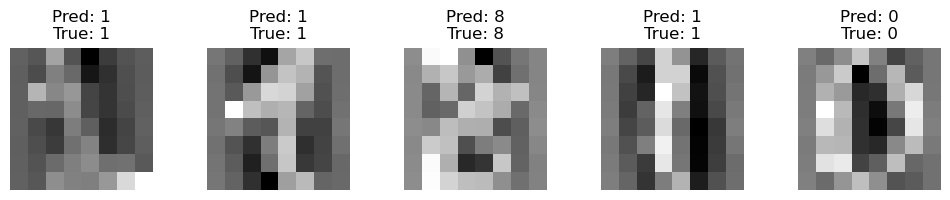

In [19]:
import matplotlib.pyplot as plt
import random

# Get 5 test samples
examples = next(iter(test_loader))
images, labels = examples

# Select 5 random indices within the batch
rand_indices = random.sample(range(images.shape[0]), 5)
images = images[rand_indices]
labels = labels[rand_indices]

# Make predictions
digit_nn.eval()
with torch.no_grad():
    outputs = model(images)
    predicted = torch.argmax(outputs, dim=1)

# Plot
plt.figure(figsize=(10, 2))
for i in range(5):
    img = images[i].reshape(8, 8)  # Reshape the 64-dim vector back to 8x8 image
    plt.subplot(1, 5, i + 1)
    plt.imshow(img, cmap="gray")
    plt.title(f"Pred: {predicted[i].item()}\nTrue: {labels[i].item()}")
    plt.axis("off")
plt.tight_layout()
plt.show()
